# Transciption de l'algorithme NLSNIP

On considère le problème d'optimisation $\left\{ \begin{array}{l l} \underset{x \in \mathbb{R}^n}{\min} \dfrac{1}{2}\|r(x)\|^2 \\ s.c\ c(x) = 0 \end{array} \right.$

Avec $r : \mathbb{R}^n \mapsto \mathbb{R}^m$ la fonction objectif et $c:\mathbb{R}^n \mapsto \mathbb{R}^q$ fonction des contraintes.

On note $f :\left\{ \begin{array}{l l} \mathbb{R}^n \mapsto \mathbb{R}\\ x \mapsto \dfrac{1}{2}\|r(x)\|^2 \end{array} \right.$ pour la suite.

Pour $x$ donné, on note $J$ et $A$ respectivement les matrices jacobiennes de $r$ et $c$ en $x$. 

In [3]:
using LinearAlgebra
using Plots
using Polynomials
using Random
using ForwardDiff

Strucure qui récapitule les informations importantes d'une itération de l'algorithme.
- $x$ : point courant
- $p$ : directon de descente
- $\alpha$ : valeur du pas
- $\lambda$ : multiplicateurs de Lagrange
- $w$ : Vecteur des poids
- $t$ : pseudo-rang de la matrice $R_{11}$ utilisé
- $s$ : pseudo-rang de la matrice $R_{22}$ utilisé
- $b = -Q_2^TP_1^Tc(x)$ : Vecteur utilisé pour résoudre le système pour $p_1$ en dimension $t$
- $d = -Q_3^T(r(x)+R_1p_1)$ : Vecteur utilisé pour résoudre le système pour $p_2$ en dimension $s$
- $\beta$ : Facteur de convergence
- $restart$ : Indique si l'étape en cours est un redémarrage de l'algorithme (explications à venir)
- $first$ : indique si l'on est dans la première itération de l'algorithme ou non
- $code$ : entier définissant la méthode utilisée pour calculer la direction de descente ($1$ pour Gauss-Newton, $-1$ pour QR-approchée et $2$ pour Newton)

In [4]:
mutable struct Iteration
    x::Vector
    p::Vector
    α::Float64
    λ::Vector
    w::Vector
    t::Int64
    s::Int64
    b::Vector
    d::Vector
    β::Float64
    restart::Bool
    first::Bool
    code::Int64
end

function show(step::Iteration)
    if step.code == 2
        phase = "Newton"
    elseif step.code == -1
        phase = "Subspace"
    else
        phase = "Gauss-Newton"
    end
    
    println("méthode : $phase")
    println("x = $(step.x)")
    println("p = $(step.p)")
    println("α = $(step.α)")
end

show (generic function with 1 method)

# Calcul des multiplicateurs de Lagrange

Le lagrangien du problème d'optimisation à résoudre est donné par :
$$\mathcal{L}:\ (x, \lambda) \mapsto f(x) + \sum_{i=1}^{q} \lambda_i c_i(x)$$ avec $\lambda = (\lambda_1,\ldots,\lambda_q) \in \mathbb{R}^q$ le vecteur des multiplicateurs de Lagrange.

Les élements de $\lambda$ sont calculés pour déterminer l'ensemble actif de l'itération en cours. Ils sont également utilisés dans le calcul de la direction de descente avec la méthode de Newton. 
Une première estimation des mulitplicateurs de Lagrange est donné par la résolution pour $\lambda$ du système :
$$ A^T\lambda = \nabla f(x)$$
Pour faire cela, on utilise la décomposition $LQ$ de $A$, ou de manière équivalente la décomposition $QR$ de $A^T$ : 
$$A = P_1\begin{pmatrix} L_{11} : 0 \end{pmatrix}Q_1^T$$
avec $Q_1^T$ matrice orthogonale $n \times n$, $L_{11}$ matrice triangulaire inférieure $q \times q$ et $P_1$ matrice de permutation $q \times q$ telle que $|l_{11}| \geq |l_{22}| \geq \cdots \geq |l_{qq}|$ (les $l_{ii}$ sont les éléments diagonaux de $L_{11}$).

Posant $v = P_1^T\lambda$, le système à résoudre devient : $L_{11}^Tv = Q_1^T\nabla f(x)$.

La fonction $\mathtt{first\_lagrange\_mult\_estimate}$ calcule cette première estimation des multiplicateurs de Lagrange à partir de la décomposition $LQ$ de $A$.

Dans le cas de contraintes d'égalité, si les mulitiplicateurs de Lagrange n'impliquent pas de supression des contraintes, on calcule une deuxième estimation de ces derniers en résolvant pour $\lambda$ :
$$ A^T\lambda = J^T\left[Jp_{GN} + r(x)\right] $$ où $p_{GN}$ est la direction de descente calculée avec la méthode de Gauss-Newton.
La résolution de ce système se fait via la fonction $\mathtt{second\_lagrange\_mult\_estimate}$.

In [5]:
function first_lagrange_mult_estimate(qr_decomp_AT::QRPivoted{Float64,Array{Float64,2}}, ∇fx::Vector)
    R = UpperTriangular(qr_decomp_AT.R)
    n, q = size(qr_decomp_AT.Q)[1], size(R)[1]
    v = [R; zeros(n-q,q)] \ (transpose(qr_decomp_AT.Q) * ∇fx)
    return qr_decomp_AT.P * v
end

first_lagrange_mult_estimate (generic function with 1 method)

# Calcul de direction de descente

Cette partie propose une explication et une implémentation des différentes fonctions utilisées pour calculer la direction de descente. La structure est plus proche de celle du code Fortran.

## Direction de descente : Méthode de Gauss-Newton

On linéarise la fonction objectif ainsi que les contraintes $r$ et $c$ à l'aide de leurs jacobiennes au voisinage d'un point $x$ selon une direction $p$  : 
$$\begin{array}{l l} f(x + p) &\approx& Jp + r(x) \\c(x+p) &\approx&  Ap + c(x)\end{array}$$

$x$ étant fixé, on cherche à résoudre le problème $\left\{ \begin{array}{l l}\underset{p \in \mathbb{R}^n }{\min} \dfrac{1}{2} \|Jp + r(x)\|^2 \\ s.c \ Ap + c(x) = 0 \end{array} \right.$
où $J$ est la jacobienne de $r$, $A$ celle de $c$ la fonction des contraintes et $x$ le point courant.

Le point de départ de cette approche est la factorisation $LQ$ de $A$ obtenue par la factorisation $QR$ de $A^T$ : $$A = P_1\begin{pmatrix} L_{11} : 0 \end{pmatrix}Q_1^T$$
avec $Q_1^T$ matrice orthogonale $n \times n$, $L_{11}$ matrice triangulaire inférieure $q \times q$ et $P_1$ matrice de permutation $q \times q$ telle que $|l_{11}| \geq |l_{22}| \geq \cdots \geq |l_{qq}|$ (les $l_{ii}$ sont les éléments diagonaux de $L_{11}$).

Soit $\overline{t} = rang(A)$ avec une tolérance de $\varepsilon_{rank} = (\mathtt{relative\_precision})^{1/2}$

$\underline{\mathbf{\overline{t} = q}}$

Par ajout de la factorisation de $A$ dans la linéarisation des contraintes d'égalité, on obtient : $$P_1L_{11}p_1 +c(x) = 0 \Longleftrightarrow L_{11}p_1 = -P_1^Tc(x) = b $$
Pour $t \leq q$, on définit $L_{11}^{(t)}$ comme le bloc triangulaire inférieur composé des $t$ premières lignes et colonnes de $L_{11}$ et $b^{(t)} = (b_1, b_2, \ldots, b_t)^T$. Par suite, posant $\delta p_1^{(t)} = (L_{11}^{(t)})^{-1}b^{(t)}$, on obtient :
$$p_1 = \begin{pmatrix} \delta p_1^{(t)} \\ 0 \end{pmatrix}$$

On pose ensuite $JQ_1 = \begin{pmatrix} J_1 & J_2 \end{pmatrix}$ ce qui donne $Jp + r(x) = JQ_1Q_1^Tp + r(x) =J_2p_2 + J_1p_1 + r(x)$.

$p_1$ étant déjà calculé, il reste à résoudre pour $p_2$ $\underset{p_2 \in \mathbb{R}^{n-q}}{\min} \dfrac{1}{2}\|J_2p_2 + (J_1p_1 + r(x))\|^2$. 

On utilise pour cela la factorisation $QR$ de $J_2 = Q_3\begin{pmatrix} R_{22} \\ 0\end{pmatrix}P_3$ 

avec $Q_3$ matrice orthogonale $m \times m$, $R_{22}$ matrice triangulaire supérieure $(n-q) \times (n-q)$ à éléments diagonaux décorissants en valeur absolue et $P_3$ matrice de permutation $(n-q) \times (n-q)$.

$d = -Q_3^T(r(x) + J_1p_1)$ et pour $s \leq n-q$, on définit $R_{22}^{(s)}$ comme le bloc triangulaire supérieur composé des $s$ premières lignes et colonnes de $R_{22}$ et $d^{(s)} = (d_1, d_2, \ldots, d_s)^T$.
Par suite, posant $\delta p_2^{(s)} = (R_{22}^{(s)})^{-1}d^{(s)}$, on obtient :
$$p_2 = P_3^T\begin{pmatrix} \delta p_2^{(s)} \\ 0 \end{pmatrix}$$.

$\underline{\mathbf{\overline{t} \neq q}}$

Si le rang de $A$ n'est pas égal à $q$, une stabilisation est requise. Pour cela, on utulise la décomposition $QR$ de $L_{11}$ : $$Q_2L_{11}P_2 = (R_{11} \ 0)$$
avec $Q_2$ matrice orthogonale $q \times q$, $R_{11}$ matrice triangulaire supérieure $q \times q$ à éléments diagonaux décorissants en valeur absolue et $P_2$ matrice de permutation $q \times q$.

L'équation des contraintes se récrit :
$$ R_{11}P_2^Tp_1 = -Q_2^TP_1^Tc(x) = b$$ 
Pour $t \leq q$, on définit $R_{11}^{(t)}$ comme le bloc triangulaire supérieur composé des $t$ premières lignes et colonnes de $R_{11}$ et $b^{(t)} = (b_1, b_2, \ldots, b_s)^T$. Par suite, posant $\delta p_1^{(t)} = (R_{11}^{(t)})^{-1}b^{(t)}$, on obtient :
$$p_1 = P_2\begin{pmatrix} \delta p_1^{(t)} \\ 0 \end{pmatrix}$$

L'approche du calcul de $p_2$ est similaire au cas précédent : on injecte $p_1$ et $p_2$ dans la fonction objectif linéarisée en décomposant $JQ_1$ par blocs. Le problème à résoudre est alors $\underset{p_2 \in \mathbb{R}^{n-q}}{\min} \dfrac{1}{2}\|J_2p_2 + (R_1p_1 + r(x))\|^2$ avec $R_1 = J_1P_2$.

On utilise la décomposition $QR$ de $J_2 = Q_3\begin{pmatrix} R_{22} \\ 0\end{pmatrix}P_3$ 

avec $Q_3$ matrice orthogonale $m \times m$, $R_{22}$ matrice triangulaire supérieure $(n-q) \times (n-q)$ à éléments diagonaux décorissants en valeur absolue et $P_3$ matrice de permutation $(n-q) \times (n-q)$.

$d = -Q_3^T(r(x) + R_1p_1)$ et pour $s \leq n-q$, on définit $R_{22}^{(s)}$ comme le bloc triangulaire supérieur composé des $s$ premières lignes et colonnes de $R_{22}$ et $d^{(s)} = (d_1, d_2, \ldots, d_s)^T$.
Par suite, posant $\delta p_2^{(s)} = (R_{22}^{(s)})^{-1}d^{(s)}$, on obtient :
$$p_2 = P_3^T\begin{pmatrix} \delta p_2^{(s)} \\ 0 \end{pmatrix}$$.

Dans les deux cas, une fois les vecteurs $p_1$ et $p_2$ calculés, la solution du problème sous contraintes de dimension $(t,s)$ est donnée par :
$$ \boxed{p^{(t,s)} = Q_1 \begin{pmatrix} p_1 \\ p_2 \end{pmatrix}}$$

La fonction $\mathtt{sub\_search\_direction}$ calcule la direction de descente avec $t$ et $s$ donnés.

In [6]:
function sub_search_direction(rx::Vector, cx::Vector, JQ1::Matrix, qr_AT::QRPivoted{Float64,Array{Float64,2}}, 
        qr_L11::QRPivoted{Float64,Array{Float64,2}}, qr_J2::QRPivoted{Float64,Array{Float64,2}}, 
        rankA::Int64, s::Int64, t::Int64 = rankA)
    ε_rank = sqrt(eps(Float64))
    q = length(cx)
    
    # Décomposition LQ de A
    P1, Q1, L11 = qr_AT.P, qr_AT.Q, transpose(qr_AT.R)
    n = size(Q1)[1]
    
    # Décomposition QR de J2
    J1, J2 = JQ1[:,1:q], JQ1[:,q+1:n]

    P3, Q3, R22 = qr_J2.P, qr_J2.Q, qr_J2.R
    
    
    # Pas de stabilisation requise
    if rankA == q
        
        # Résout L11*p1 = -P1^T*c(x)
        b = - transpose(P1) * cx
        δp1 = LowerTriangular(L11[1:t, 1:t]) \ b[1:t] 
        p1 = [δp1; zeros(q - t)]

        
        
        # Résout min [0.5*||J2 * p2 + r(x) + J1*p1||^2]
        d = - transpose(Q3) * (J1 * p1 + rx)
        δp2 = UpperTriangular(R22[1:s, 1:s]) \ d[1:s]
        p2 = transpose(P3) * [δp2; zeros(n - q - s)]

        
    else
        # Stabilisation nécessaire
        
        # Décomposition QR de L11
        P2, Q2, R11 = qr_L11.P, qr_L11.Q, qr_L11.R

        # Résout R11 * P2^T * p1 = -Q2^T * P1^T * c(x)
        b = -transpose(P1 * Q2) * cx
        δp1 = UpperTriangular(R11[1:t, 1:t]) \ b[1:t]
        p1 = P2 * [δp1; zeros(q - t)]


        
        # Résout min [0.5*||J2 * p2 + f(x) + R1*p1||^2]
        R1 = J1 * P2
        d = -transpose(Q3) * (rx + R1*p1)
        δp2 = UpperTriangular(R22[1:s, 1:s]) \ d[1:s]
        p2 = transpose(P3)*[δp2; zeros(n - q - s)]
    end
    p = Q1 * [p1; p2]
    
    return p, b, d
end  

sub_search_direction (generic function with 2 methods)

### Directon de Gauss-Newton : rang plein
Dans le cas de la direction de Gauss-Newton rang plein, les dimensions $t$ et $s$ sont fixées respectivement par $rang(A)$ et $rang(J_2)$.


In [7]:
function gn_search(rx::Vector, cx::Vector, A::Matrix, J::Matrix, 
        qr_decomp_AT::QRPivoted{Float64,Array{Float64,2}}, qr_decomp_L11::QRPivoted{Float64,Array{Float64,2}}, 
        qr_decomp_J2::QRPivoted{Float64,Array{Float64,2}}, rankA::Int64, rankJ2::Int64)
    

    JQ1 = J * qr_decomp_AT.Q
    p, b, d = sub_search_direction(rx, cx, JQ1, qr_decomp_AT, qr_decomp_L11, qr_decomp_J2, rankA, rankJ2)
    
    return p, b, d
end   

gn_search (generic function with 1 method)

### Vérification de la direction de la direction de Gauss-Newton

Une fois la direction de Gauss-Newton calculée avec rang plein, on appelle la fonction $\mathtt{check\_gn\_direction}$ afin de savoir si on accepte cette direction pour l'itération ou bien s'il faut la recalculer en utilisant une des deux méthodes décrites dans la suite : Gauss-Newton $QR$ approchée ou Newton.

In [8]:
function check_gn_direction(x::Vector, r::Function, c::Function, J::Matrix, A::Matrix, d::Vector, b::Vector, 
        rankA::Int64, rankJ2::Int64, previous_step::Iteration)

    # Renvoie un entier method_code qui peut valoir :
    # 1 si la direction est Gauss-Newton est acceptée
    # -1 si la minimisation de sous-espace est suggérée
    # 2 si la méthode de Newton est suggérée

    # Constantes
    c1, c2, c3, c4, c5 = 0.5, 0.1, 4.0, 10.0, 0.05
    δ = 0.1
    ε_rel = eps(Float64)
    ε_rank = sqrt(eps(Float64))

    # Informations relatives à l'étape précédente

    ω_t, ω_s = previous_step.t, previous_step.s
    b1, d1 = b[1:rankA], d[1:rankJ2]
    norm_d, norm_d1, norm_d1_previous  = norm(d), norm(d1), norm(d[1:ω_s - 1])
    norm_b, norm_b1 = norm(b), norm(b1)
    normd1_2, normb1_2 = dot(d1, d1), dot(b1, b1)
    prelin = dot(d[1:ω_s], d[1:ω_s])
    β = sqrt(normd1_2 + normb1_2)
    previous_step.β = β

    rx_previous, rx, cx = r(previous_step.x), r(x), c(x)
    progress = dot(rx_previous, rx_previous) - dot(rx, rx)
    hsum = dot(cx, cx)


    # Pour accepter le direction de Gauss-Newton, il ne faut pas être dans uen étape de redémarrage 
    # et ne pas avoir utulisé la méthode de Newton à l'étape précédente
    if !previous_step.restart || previous_step.method_code != 2
        
        # On accepte Gauss-Newton si l'une des trois conditions suivantes est vérifiée
        if previous_step.first || β > c1 * previous_step.β || (progress > c2 * prelin && norm_d <= c3 * β)
            return 1
        end
    end

    non_linearity = sqrt(normd1_2 + hsum)
    previous_non_linearity = sqrt(dot(d[1:ω_s - 1], d[1:ω_s - 1]) + hsum)
    ϵ = max(1e-2, 10. * ε_rel)
    # à rajouter : les conditions spécifiques aux contraintes d'inégalité
    # Minimisation de sous-espace si une des conditions suivantes est vraie

    if hsum > c2 || !(β < ϵ * norm_d || norm_b1 < ϵ) || norm_d <= c4 * β
        return -1
    end

    if previous_step.restart
        if previous_non_linearity > c2 * non_linearity
            method_code = (previous_non_linearity > c2 * non_linearity ? -1 : 2)
        end
    elseif previous_step.α < c5 && previous_non_linearity < c2 * non_linearity
        method_code = 2
    end
    return method_code
end

check_gn_direction (generic function with 1 method)

### Direction de Gauss-Newton : QR approchée
Cette méthode est utilisée si la direction de Gauss-Newton calculée avec rang plein n'est pas bonne. La fonction $\mathtt{subspace\_dimension}$ retourne les dimensions $t$ et $s$ à utiliser dans le calcul de la direction de descente.

In [9]:
function subspace_dimension(x::Vector, r::Function, c::Function, J::Matrix, A::Matrix, 
        qr_AT::QRPivoted{Float64,Array{Float64,2}}, qr_L11::QRPivoted{Float64,Array{Float64,2}}, 
        qr_J2::QRPivoted{Float64,Array{Float64,2}}, previous_step::Iteration)
    
    # Informations utiles de l'itération précédente
    x_previous, b_previous, d_previous = previous_step.x, previous_step.b, previous_step.d
    α_previous = previous_step.α
    ω_t, ω_s = previous_step.t, previous_step.s
    
    # Matrices et constantes utiles pour la suite
    q, n = size(A)
    J1 = (J * qr_AT.Q1)[:, 1:q]
    L11 = LowerTriangular(transpose(qr_AT.R))
    rankA = rank(L11, ε_rank)
    rankJ2 = rank(UpperTriangular(qr_J2.R), ε_rank)
    
    # Progressions linéaire des résidus et des contraintes suite à l'itération précédente
    rx, rx_previous, cx, cx_previous = r(x), r(x_previous), c(x), c(x_previous)
    c_progress = dot(cx_previous, cx_previous) - dot(cx, cx)
    r_progress = dot(rx_previous, rx_previous) - dot(rx, rx)
    
    # Calcul de la dimension t
    b = - transpose(qr_AT.P * qr_L11.Q) * cx
    βb_previous = dot(b_previous[1:ω_t], b_previous[1:ω_t])
    βb_current = dot(b[1:ω_t], b[1:ω_t])
    t = compute_solving_dim(UpperTriangular(qr_L11.R), b, ω_t, rankA, c_progress, βb_previous, βb_current, 
        α_previous, previous_step.restart)
    
    # Calcul de la dimension s
    p1 = UpperTriangular(qr_L11.R) \ b[1:t]
    d = - transpose(qr_J2) * (rx + J1 * qr_L11.P * p1)
    βd_previous = dot(d_previous[1:ω_s], d_previous[1:ω_s])
    βd_current = dot(d[1:ω_s], d[1:ω_s])
    
    s = compute_solving_dim(UpperTriangular(qr_J2.R), d, ω_s, rankJ2, c_progress, βd_previous, βd_current, 
        α_previous, previous_step.restart)
    
    return t, s, b, d
end
    
    
    

subspace_dimension (generic function with 1 method)


La fonction $\mathtt{compute\_solving\_dim}$ détermine la dimension à utiliser dans la résolution pour un vecteur $x$ de $Rx = b$ avec $R$ matrice triangulaire supérieure et $b$ un vecteur. Cette dimension correspond au nombre de colonnes de $R$ que l'on souhaite annuler. 

Cette fonction est utlisée pour calculer les entiers $t$ et $s$ décrits au-dessus. 
Pour $t$ on applique la fonction au système d'inconnue $p_1$ $R_{11}P_2^Tp_1 = -Q_2^TP_1^Tc(x)$, pour $s$ à celui d'inconnue $p_2$ $R_{22}p_2 = -Q_3^T(r(x) + R_1p_1)$

In [10]:
function compute_solving_dim(R::UpperTriangular{Float64,Array{Float64,2}}, b::Vector, ω::Int64, 
        rankR::Int64, progress::Float64, previous_β::Float64, current_β::Float64, 
        previous_α::Float64, restart::Bool = false)
    
    new_dim = rankR
    working_set, h = zeros(rankR), zeros(rankR)
    working_set[1], h[1] = abs(b[1]), abs(b[1] / R[1, 1])

    # Compute working_set and vector h : lenghts of estimated search direction
    # and righthand sides
    if t_acc > 1
        for i = 2 : rankR
            working_set[i] = b[i]
            h[i] = b[i] / R[i, i]
            h[i] = norm(h[i-1:i])
            working_set[i] = norm(working_set[i-1:i])
        end
    end

    # Determine lowest possible dimension
    Σd, ϱmax, mindim = 0., 0., 1
    ϱ = sqrt(Σh) * abs(R[1,1])
    for i = 1 : rankR
        Σd += h[i]^2
        ϱ = sqrt(Σh) * abs(R[i,i])
        if ϱ > ϱmax
            ϱmax = ϱ
            mindim = i
        end
    end

    if !restart
        # When restart is false η is set to 1
        η = 1.
        if ω == rankR || ω <= 0
            dim = gn_previous_step(h, working_set, rankR, mindim)

        elseif ω != rankR && ω > 0
            dim = subspace_minimization(h, working_set, ω, progress, previous_β, current_β, previous_α)
        end
        new_dim = max(mindim, dim)
    else
        dim = min(rankR, ω)
        new_dim = max(dim, 0)

        if new_dim == 0
            η = 1.
        else
            k = (ω == 1 ? 1 : ω - 1)
            η = (h[new_dim] != 0 ? h[k] / h[new_dim] : 1.)
        end
    end

    return new_dim, η
end

compute_solving_dim (generic function with 2 methods)

La fonction $\mathtt{gn\_previous\_step}$ fait le calcul de dimension dans le cas où la précédente direction de descnete calculée était une Gauss-Newton rang plein.

La fonction $\mathtt{subspace\_minimization}$ fait de même mais dans le cas où la méthode TQR approchée avait été utilisée à l'étape précédente.

In [11]:
function gn_previous_step(h::Vector, working_set::Vector, t_acc::Int64, mindim::Int64)
    h_last, wrkset_last = h[t_acc], working_set[t_acc]
    h_max, wrkset_min = 0.2, 0.5
    m1, = t_acc - 1
    if mindim > m1
        dim = mindim
    else
        try
            dim = maximum([k for k = mindim:m1 if h[i] < h_max * h_last && 
                                working_set[i] > wrkset_last * wrkset_min])
        catch
            # No such index exists, then t_acc - 1 in return
            dim = m1
        end
    end
    return dim
end


function subspace_minimization(h::Vector, working_set::Vector, ω::Int64, progress::Float64, 
            previous_β::Float64, current_β::Float64, previous_α::Float64)
        
    # Constantes
    stepb, pgb1, pgb2, predb, rlenb, c1, c2 = 0.2, 0.3, 0.1, 0.7, 2., 0.1, 100.
    h_last, wrkset_last = h[t_acc], working_set[t_acc]

    # Tests si l'étape précédente était mauvaise
    if previous_α < stepb || progress <= pgb1 * previous_β^2 || progress <= pgb2 * current_β^2
        dim = max(1, ω - 1)
        if ω > 1 && working_set[dim] > c1 * h_last
            return dim
        end
    # L'étape pérédente était bonne : pas besoin de modifier la dimension
    elseif working_set[dim] > predb * wrkset_last && rlenb * h[dim] < h[dim + 1]
        return ω
    end
    # Test possible rank defficiency
    if c2 * d[dim] <= d[dim + 1] return dim end

    try
        dim = minimum([i for i= ω+1:t_acc if working_set[i] > predb * wrkset_last])
    catch
        dim = t_acc

    end
    return dim
end

subspace_minimization (generic function with 1 method)

## Direction de descente : Méthode de Newton

Dans certaines situations, la méthode de Gauss-Newton (rang plein ou approchée) ne peut être utilisée. C'est par exemple le cas si l'on est proche de la solution. Dans ce cas, la direction de descente est calculée par une méthode de Newton. On rappelle les décompositions  : 
- $A = P_1\begin{pmatrix} L_{11} & 0 \end{pmatrix}Q_1^T$
avec $Q_1$ matrice orthogonale $n \times n$, $L_{11}$ matrice triangulaire inférieure $q \times q$ et $P_1$ matrice de permutation $q \times q$ telle que $|l_{11}| \geq |l_{22}| \geq \cdots \geq |l_{qq}|$ (les $l_{ii}$ sont les éléments diagonaux de $L_{11}$).
- $Q_2L_{11}P_2 = R_{11}$
avec $Q_2$ matrice orthogonale $q \times q$, $R_{11}$ matrice triangulaire supérieure $q \times q$ à éléments diagonaux décorissants en valeur absolue et $P_2$ matrice de permutation $q \times q$.

La direction de Newton est calculée via la résolution du problème :

$$ \left\{\begin{array}{l l} \underset{p \in \mathbb{R}^n}{\min} \dfrac{1}{2} p^T\left[J^TJ - \sum_{i=1}^{q}\lambda_i\nabla^2c_i(x) + \sum_{i=1}^{m}r_i(x)\nabla^2r_i(x)\right]p + \left[J^Tr(x)\right]^Tp \\ 
s.c\ 
\begin{array}{l l} (L_{11}\ 0)Q_1^Tp = -P_1^Tc(x) & si \ rang(A)=q \\ \begin{pmatrix}R_{11}\\ 0\end{pmatrix}P_2^TQ_1^Tp = -Q_2^TP_1^Tc(x) & si \ rang(A)<q \end{array} \end{array} \right.$$

où $\nabla^2 r_i$ (resp. $\nabla^2 c_i$) désigne la matrice hessienne du $i^{ème}$ résidu (resp. de la $i^{ème}$ contrainte).
On posera $\Gamma = - \sum_{i=1}^{q}\lambda_i\nabla^2c_i(x) + \sum_{i=1}^{m}r_i(x)\nabla^2r_i(x)$ pour la suite. On peut vérifier que $\Gamma$ est symétrique comme combinaison linéaire de matrices symétriques. 

Comme pour la méthode Gauss-Newton, on pose $Q_1^Tp = \begin{pmatrix} p_1\\p_2\end{pmatrix}$, $p_1 \in \mathbb{R}^q, p_2 \in \mathbb{R}^{n-q}$ et $JQ_1 = \begin{pmatrix}J_1 & J_2 \end{pmatrix}$.

$\mathbf{Si \ rang(A) = q}$

Soit $b_1 = -P_1^Tc(x)$, la contrainte s'écrit alors $L_{11}p_1 = b_1$ qui donne $p_1 = L_{11}\backslash b_1$.

$\mathbf{Si \ rang(A) \neq q}$


Le premier système à résoudre devient $R_{11}P_2^Tp_1 = b_2$ et la solution est donnée par $p_1 = P_2 \times(R_{11} \backslash \ b_2)$

La suite est indépendante du rang de $A$ :

Puisque $Q_1Q_1^T = I_n$, on a :
$$\begin{array}{l l l} 
\dfrac{1}{2}p^T\left[J^TJ + \Gamma\right]p + \left[J^Tr(x)\right]^Tp &= \dfrac{1}{2}p^T\left[Q_1Q_1^TJ^TJQ_1Q_1^T + Q_1Q_1^T\Gamma Q_1Q_1^T\right]p + \left[J^Tr(x)\right]^TQ_1Q_1^Tp \\
&= \dfrac{1}{2}(p_1^T\ p_2^T) \left[Q_1^TJ^TJQ_1 + Q_1^T\Gamma Q_1\right]\begin{pmatrix} p_1 \\ p_2\end{pmatrix} + \left[(JQ_1)^Tr(x)\right]^T\begin{pmatrix}p_1\\p_2\end{pmatrix} \\
&= \dfrac{1}{2}(p_1^T\ p_2^T)W\begin{pmatrix}p_1\\p_2\end{pmatrix} + b^T\begin{pmatrix}p_1\\p_2\end{pmatrix} = \varphi(p_2)
\end{array}$$

Avec $W = Q_1^TJ^TJQ_1 + Q_1^T\Gamma Q_1$ matrice $n\times n$ qui est trivialement symétrique et $b = (J_1\ J_2)^Tr(x) \in \mathbb{R}^n$. $p_1$ étant fixé, on souhaite minimiser $\varphi$ afin de trouver la solution du problème. 


On pose $E =  Q_1^TJ^TJQ_1 = \begin{pmatrix} E_{11}\ E_{12} \\ E_{21}\ E_{22} \end{pmatrix}$ avec $E_{11}: q\times q, E_{12}: q\times (n-q), E_{21}: (n-q)\times q, E_{22}: (n-q)\times (n-q)$.

On fait le même découpage de $W = \begin{pmatrix} W_{11}\ W_{12} \\ W_{21}\ W_{22} \end{pmatrix}$. Tous les blocs sont évidemment symétriques et on a $W_{12}^T = W_{21}$

Puisque $Q_1^TJ^TJQ_1 = (JQ_1)^T(JQ_1) = \begin{pmatrix} J_{1}^T \\ J_{2}^T \end{pmatrix}\times \begin{pmatrix} J_{1} & J_{2} \end{pmatrix} = \begin{pmatrix} J_{1}^TJ_1 & J_1^TJ_2 \\ J_2^TJ_1 & J_2^TJ_2 \end{pmatrix}$, on a :

$\begin{array}{l l} W_{22} = E_{22} + J_2^TJ_2 \\ W_{21} = E_{21} + J_2^TJ_1\end{array}$

Réécrivons $\varphi$ afin de faciliter les calculs de gradient et de hessienne : 
$$\begin{array}{l l l } \varphi(p_2) &= \dfrac{1}{2}(p_1^T\ p_2^T)W\begin{pmatrix}p_1\\p_2\end{pmatrix} + b^T\begin{pmatrix}p_1\\p_2\end{pmatrix} \\ &= \dfrac{1}{2} \begin{pmatrix}p_1^TW_{11}+p_2^TW_{21}\\p_1^TW_{12}+p_2^TW_{22}\end{pmatrix}\begin{pmatrix}p_1\\p_2\end{pmatrix} + \left[J_1r(x)\right]^Tp_1 + \left[J_2r(x)\right]^Tp_2 \\
&= \dfrac{1}{2} \left[ p_1^TW_{11}p_1 + p_1^TW_{12}p_2 + p_2^TW_{21}p_1 + p_2^TW_{22}p_2  \right]  +\left[J_1r(x)\right]^Tp_1 + \left[J_2r(x)\right]^Tp_2 
\end{array}$$

Or, comme $W_{12} = W_{21}^T$, on a $p_1^TW_{12}p_2 = p_1^TW_{21}^Tp_2 = p_2^TW_{21}p_1$

D'où $\varphi(p_2) = \dfrac{1}{2} \left[2p_2^TW_{21}p_1 + p_2^TW_{22}p_2\right] + p_2^TJ_2r(x) + K$ avec K indépendant de p_2. Les blocs de $W$ étant symétriques :
$$ \begin{array}{l l}\nabla \varphi(p_2) &=& W_{21}p_1 + W_{22}p_2 + J_2r(x) \\
\nabla^2 \varphi(p_2) &=& W_{22} \end{array}$$

Si $W_{22}$ est définie positive, $p_2$ est donné par la résolution du système : $W_{22}p_2 = -W_{21}p_1 -  J_2r(x) = d$ avec la factorisation de Cholesky de $W_{22}$. Sinon, on renvoit une erreur et l'itération en cours est un échec.

$\mathbf{Si \ rang(A) \neq q}$


Le premier système à résoudre devient $R_{11}P_2^Tp_1 = b_2$ et la solution est donnée par $p_1 = P_2 \times(R_{11} \backslash \ b_2)$

Pour $p_2$, on utilisera la même approche que dans le cas précédent.

In [12]:
function newton_search_direction(x::Vector, A::Matrix, J::Matrix, r::Function, c::Function,
        qr_transpA::QRPivoted{Float64,Array{Float64,2}}, qr_L::QRPivoted{Float64,Array{Float64,2}}, 
        λ::Vector, rankA::Int64, previous_step::Iteration)
    ε_rank = sqrt(eps(Float64))
    rx, cx = r(x), c(x)
    m, n = size(J)
    q = length(cx)
    Q1 = qr_transpA.Q
    JQ1 = J * Q1
    J1, J2 = JQ1[:,1:q], JQ1[:,q+1:n]
    
    # Calcul de p1
    b1 = -transpose(qr_transpA.P) * cx
    if rankA == q 
        p1 = LowerTriangular(transpose(qr_transpA.R)) \ b1
    else
        b2 = transpose(qr_L.Q) * b1
        p1 = qr_L.P * (UpperTriangular(qr_L.R) \ b2)
    end
    
        
    # Préparation au calcul de p2
    
    # Calcul de Γ
    
    rmat, cmat = zeros(n, n), zeros(n, n)
    for i=1:m
        hess_i(x) = ForwardDiff.hessian(x -> r(x)[i], x)
        rmat += rx[i] * hess_i(x)
    end
    for i=1:q
        hess_i(x) = ForwardDiff.hessian(x -> c(x)[i], x)
        cmat += λ[i] * hess_i(x)
    end
    Γ = rmat - cmat
    
    # Blocs intéressants pour le calcul de p2
    
    E = transpose(Q1) * Γ * Q1
    E21, E22 = E[q+1:n, 1:q], E[q+1:n, q+1:n]
    
    W21, W22 = E21 + transpose(J2) * J1, E22 + transpose(J2) * J2
    try
        chol_W = cholesky(Symmetric(W22), Val(true), tol = ε_rank, check = true)
        d = -W21 * p1 - J2 * rx
        δp2 = chol_W.L \ d
        p2 = chol_W.U \ δp2
        p = Q1 * [p1; p2]
        previous_step.restart = false
        return p
    catch
        previous_step.restart = true
        p = zeros(n)
    finally
        return p
    end 
end

newton_search_direction (generic function with 1 method)

# Calcul du pas



On considère la fonction de mérite $$\psi(x,w) = \dfrac{1}{2}\|r(x)\|^2 +  \dfrac{1}{2}\sum_{i=1}^{q} w_ic_i(x)^2 $$

$x$ et $p$ dans $\mathbb{R}^n$ sont respectivement le point courant et la direction de descente de l'itération en courant.

Le pas de l'itération est calculé en minimisant la fonction de mérite à direction et point fixés : 
$$\phi : \alpha \mapsto \dfrac{1}{2}\|r(x+\alpha p)\|^2 +  \dfrac{1}{2}\sum_{i=1}^{q} w_ic_i(x+\alpha p)^2$$
où $w \in \mathbb{R}^q$ est le vecteur des poids actualisé à chaque nouvelle direction de descente calculée.

### Mise à jour du vecteur de poids

Avant de minimiser $\phi$, il faut mettre à jour le vecteur de poids.

En utilisant les approximations linéaires suivantes de $r$ et $c$ à l'aide de leurs jacobiennes au voisinage du point courant $x$ selon une direction $p$ et un pas $\alpha$ : 
$$\begin{array}{l l} f(x+\alpha p) \approx \alpha Jp + r(x) \\c(x+\alpha p) \approx \alpha Ap + c(x)\end{array}$$

En introduisant $W = diag(w_1, \ldots, w_q)$, on remarque que $\sum\limits_{i=1}^{q} w_ic_i(x)^2 = c(x)^TWc(x)$

On a alors
$$\begin{array}{l l} \phi(\alpha) \approx \phi_2(\alpha) &= \dfrac{1}{2} \left[ \|\alpha Jp+r(x)\|^2 + (\alpha Ap + c(x))^TW(\alpha Ap + c(x)) \right]  \\
&= \dfrac{\alpha^2}{2} \left[ \|Jp\|^2 + (Ap)^TWAp \right] + \alpha \left[ (Jp)^Tr(x) + (Ap)^TWc(x) \right] + K \end{array}$$ avec $K$ indépendant de $\alpha$.

On remarque que $\phi(0) = \phi_2(0)$ et $\phi^{\prime}(0) = \phi_2^{\prime}(0)$ (? à vérifier)

Les poids $w_i$ doivent être choisis suffisamment grands pour que $p$ soit une direction descente de $\psi$ ou, de façon équivalente que $\phi_2^{\prime}(0) < 0$ implique que le minimum de $\phi$ soit atteint pour $\alpha > 0$. On choisit des poids tels que ce minimum soit atteint pour $\alpha$ proche de $1$ par soucis de consistence avec le problème de moindres carrés initial, i.e $1-\delta_1 \lt \alpha \lt 1+\delta_2$ ,avec $0 \lt \delta_i \lt 1$. On prendra $\delta_1 = \delta_2$ afin d'avoir  $|\alpha -1| \lt \delta$ comme critère.
($\delta = 0.25$ dans le code Fortran).
Puisque $\phi_2$ est une fonction quadratique, ce minimum est atteint en $\alpha = -\dfrac{\phi_2^{\prime}(0)}{\phi_2^{\prime\prime}(0)}$

Cela donne $$\alpha(W) =  \dfrac{-(Ap)^TWc(x)-(Jp)^Tr(x)}{(Ap)^TWAp+\| Jp\|^2}$$

On se sert également du scalaire $$\mu = \dfrac{\left| (Jp)^Tr(x) + \|Jp\|^2\ \right|}{\delta} - \|Jp\|^2$$ que  ce soit avec la méthode norme max ou norme euclidienne.

Le choix entre ces deux méthodes est décidé par la valeure d'une constante du code $\texttt{weight-norm}$ qui vaut $0$ pour utiliser la norme max, $2$ pour la norme euclidienne. Par défaut, $\texttt{weight-norm} = 2$ dans l'algorithme en Fortran.

La fonction $\texttt{assort}$ met à jour le vecteur $K$ avec le nouveau vecteur de poids de sorte que chaque ligne du tableau soit rangée dans l'ordre décorissant.

In [13]:
function assort!(K::Array{Array{Float64,1},1}, w::Vector)
    ξ, q = length(K), length(w)
    for i = 1:q
        not_inserted, k = true, 1
        while not_inserted && k <= ξ
            if w[i] <= K[k][i]
                k += 1
            else
                for j = ξ:-1:k+1
                    K[j][i] = K[j-1][i]
                end
                K[k][i] = w[i]
                not_inserted = false
            end
        end
    end
end

assort! (generic function with 1 method)

#### 1. Utilisation de la norme $\max$

Dans ce cas ce figure, à l'itération $k$,  on a $w^{(k)} = \nu^{(k)}\mathbb{1}_q$ avec $\nu^{(k)}$ un scalaire que l'on cherche à calculer (tous les poids ont la même valeur).

$\kappa$ est le vecteur des $\xi$ dernières valeurs de poids avec $\kappa_1 \geq \kappa_2 \geq \ldots \geq \kappa_{\xi}$ (valeur de 4 conseillée dans l'article principal p.17)  

La mise à jour des poids se fait selon l'algorithme décrit ci-dessous

In [14]:
function max_norm_weight_update(A::Matrix, p::Vector, δ::Float64, μ::Float64, α_w::Float64, 
        K::Array{Array{Float64,1},1}, w_old::Vector)
    q, ξ = size(A)[1], length(K)
    μ_new = (abs(α_w - 1) <= δ ? 0 : μ / norm(A * p)^2)
    ν = max(μ_new, K[ξ][1])
    w = ν * ones(q)
    
    # Assort first line of K if new value is superior to the old one
    assort!(K, w)
    return w  
end  

max_norm_weight_update (generic function with 1 method)

#### 2. Utilisation de la norme euclidienne

Ici, on calcule le vecteur des poids par la résolution du problème d'optimisation : 
$$\left\{ \begin{array}{l l} \underset{w \in \mathbb{R}^q}{\min} \|w\| \\ sc\  \begin{array}{l l}  y^Tw &\geq& \tau \\ w_i &\geq& w_i^{(old)}, \, 1 \leq i \leq q \end{array} \end{array} \right.$$

<b> N.B </b> : La première contrainte peut être une contrainte d'égalité selon les configurations.

Le vecteur $y$ et le scalaire $\tau$ sont préalablement calculés en fonction des valeurs de $\mu =  \left[\dfrac{|(Jp)^Tf(x_k) + \|Jp\|^2|}{\delta} - \|Jp\|^2 \right]$ et $z = \left[ (\nabla c_i(x)^Tp)^2 \right]_{1 \leq i \leq q}$

L'algorithme $\texttt{euclidean_norm-weight-update}$ calcule paramètre le probèlme d'optimisation sur $w$ qui est ensuite résolu par l'appel de la fonction $\texttt{minimize-euclidean-norm}$.

C'est cette méthode qui est utilisée par défaut dans l'algorithme écrit en Fortran

In [15]:
function minimize_euclidean_norm(w_old::Vector, y::Vector, τ::Float64)
    q = length(w_old)
    w = w_old[:]
    if norm(y, Inf) > 0
        τ_new = τ
        y_norm = norm(y)
        for i = 1:q
            c = τ_new / y_norm^2
            if y[i] != 0
                prod = c * y[i]
                prod >= w_old[i] ? w[i] = prod : τ_new -= w_old[i] * y[i]
            end
        end
    end
    return w
end

minimize_euclidean_norm (generic function with 1 method)

In [16]:
function euclidean_norm_weight_update(A::Matrix, cx::Vector, p::Vector,ω::Int64, μ::Float64, 
        K::Array{Array{Float64,1},1})
    # Initialization of variables
    ξ = length(K)
    w_old = K[ξ][:]
    q, n = size(A)
    vA = A * p
    y, z = zeros(q), vA[:].^2
    ztw = dot(z, w_old)
    w = w_old[:]
    
    # No changes of weights if z^Tw >= μ and ω = q
    
    if ztw >= μ
        
        if ω < q
            γ = 0
            for i=1:q
                y_el = vA[i] * (vA[i] + cx[i])
                y_el <= 0 ? γ -= y_el * w_old[i] : y[i] = y_el
            end
            w = minimize_euclidean_norm(w_old, y, γ)
        end
        
    
    elseif ztw < μ
        if ω < q
            τ = μ
            for i=1:q
                y_el = - vA[i] * cx[i]
                y_el <= 0 ? τ -= y_el * w_old[i] : y[i] = y_el
            end
        else
            y, τ = z[:], μ
        end
        w = minimize_euclidean_norm(w_old, y, τ)
        
    end
    
    # Met à jour le vecteur K si les nouvelles valeurs de poids sont supérieures aux anciennes
    assort!(K, w)
    
    return w
end

euclidean_norm_weight_update (generic function with 1 method)

Fonction de mise à jour des poids : $\mathtt{compute\_penalty\_weights}$

In [17]:
function compute_penalty_weights(r::Function, J::Function, c::Function, A::Function, x::Vector, p::Vector,
        ψ::Function, K::Array{Array{Float64,1},1}, weight_norm::Int64, last_step::Iteration)
    δ = 0.25
    Ap, Jp, rx, cx = A(x) * p, J(x) * p, r(x), c(x)
    
    # Poids utilisés dans la dernière itération 
    last_w = last_step.w
    
    atwa, jtj = dot(Ap, last_w.*Ap), dot(Jp, Jp)
    
    if atwa == jtj
        α_w = 1.0
    else
        α_w = (-dot(Ap, last_w.* cx) - dot(Jp, rx)) / (atwa + jtj)
    end
    
    μ = abs(dot(Jp, rx) + jtj) / δ - jtj
    
    if weight_norm == 0
        w = max_norm_weight_update(A(x), p, δ, μ, α_w, K, last_w)
    else
        w = euclidean_norm_weight_update(A(x), cx, p, last_step.t, μ, K) 
    end
    return w
end

compute_penalty_weights (generic function with 1 method)

### Minimisation de $\psi$ par approximation polynomiale

La fonction $\texttt{minrn}$ renvoie le minimum de la fonction quadratique passant par trois points $y_1, y_2, y_3$ respectivement en $x_1, x_2$ et $x_3$ 

Cette fonction est utilisée pour calculer une estimation du minimum de la fonction de mérite en calculant celui de la quadratique inteprolant $\psi$ en trois points $\alpha_{-1}$, souvent $\alpha_0$ et $\alpha_1$.

In [18]:
function minimize_quadratic(x1::Float64, y1::Float64, x2::Float64, y2::Float64,
    x3::Float64, y3::Float64)

    d1, d2 = y2 - y1, y3 - y1
    s = (x3 - x1)^2 * d1 - (x2 - x1)^2 * d2
    q = 2 * ((x2 - x1) * d2 - (x3 - x1) * d1)
    return x1 - s / q
end

function minrn(x1::Float64, y1::Float64, x2::Float64, y2::Float64,
    x3::Float64, y3::Float64, α_min::Float64, α_max::Float64)

    εrank = sqrt(eps(Float64))

    # α not computable
    # Add an error in this case
    if abs(x1 - x2) < εrank || abs(x3 - x1) < εrank || abs(x3 - x2) < εrank
        α, pα = 0., 0.

    else
    # Compute minimum of quadradic passing through fx, fv and fw
    # at points x, v and w
        u = minimize_quadratic(x1, y1, x2, y2, x3, y3)
        α = clamp(u, α_min, α_max)
        t1 = (α - x1) * (α - x2) * y3 / ((x3 - x1) * (x3 - x2))
        t2 = (α - x3) * (α - x2) * y1 / ((x1 - x3) * (x1 - x2))
        t3 = (α - x3) * (α - x2) * y2 / ((x2 - x1) * (x2 - x3))
        
        # Value of the estimation of ψ(α)
        pα = t1 + t2 + t3
    end
    
    return α, pα
end

minrn (generic function with 1 method)

$\texttt{minrm}$ renvoie le point minimisant la fonction polynomiale
$$P(\alpha) = \dfrac{1}{2}\|v_2\alpha^2 + v_1\alpha + v_0\|^2$$

Avec $v_0$, $v_1$ et $v_2$ dans $\mathbb{R}^{m+q}$ qui s'expriment par, 

Notant $F(\alpha) = \left[r_1(x+\alpha p), \ldots, r_m(x+\alpha p), \sqrt{w_1}c_1(x+\alpha p), \ldots, \sqrt{w_q}c_q(x+\alpha p)\right]^{T}$ et $\alpha_k$ la valeur courante du pas dans l'algorithme de recherche linéaire : 

$\begin{array}{l l l}
v_0 = F(0) \\
v_1 = \left[\nabla r_1(x)^Tp,\ldots, \nabla r_m(x)^Tp, \sqrt{w_1}\nabla c_1(x)^Tp, \ldots, \sqrt{w_q}\nabla c_q(x)^Tp \right]^T \\
    v_2 = \left[ \dfrac{1}{\alpha_k}\left( \dfrac{F_i(\alpha_k) - v_0^{(i)}}{\alpha_k} - v_1^{(i)}\right)\right]_{1 \leq i \leq m+q}^T
\end{array}$

Le polynôme $P$ ainsi formé avec les cofficients ci-dessus interpole $\phi$ en $0$ et $\alpha_k$.

In [19]:
function parameters_rm(v0::Vector, v1::Vector, v2::Vector, α_best::Float64,
        ds::Polynomial{Float64}, dds::Polynomial{Float64})
    dds_best = dds(α_best)
    η, d = 0.1, 1.
    normv2 = dot(v2, v2)
    h0 = abs(ds(α_best) / dds_best)
    Dm = abs(6 * dot(v1,v2) + 12 * α_best*normv2) + 24 * h0 * normv2
    hm = max(h0, 1)

    # s'(α) = 0 is solved analytically
    if dds_best * η < 2 * Dm * hm
        
        # If t = α+a1 solves t^3 + b*t + c = O then α solves s'(α) = 0
        (a3, a2, a1) = coeffs(ds) / (2 * normv2)
        
        b = a2 - (a1^2) / 3
        c = a3 - a1 * a2/3 + 2*(a1/3)^3
        d = (c/2)^2 + (b/3)^3
        # Two interisting roots
        if d < 0
            α_hat, β_hat = two_roots(b, c, d, a1, α_best)
        
        # Only one root is computed     
        else
            α_hat = one_root(c, d, a1)
        end
    
    # s'(α) = 0 is solved using Newton-Raphson's method
    else
        α_hat = newton_raphson(α_best, Dm, ds, dds)
    end
    
    # If only one root computed
    if d >= 0 
        β_hat = α_hat 
    end
    return α_hat, β_hat
    
end

function bounds(α_l::Float64, α_u::Float64, α::Float64, s::Polynomial{Float64})
    α = min(α, α_u)
    α = max(α, α_l)
    return α, s(α)
end

function newton_raphson(α_best::Float64, Dm::Float64, ds::Polynomial{Float64}, dds::Polynomial{Float64})
    α, newtonstep = α_best, 0
    ε, error = 1e-4, 1.
    while error > ε || newtonstep < 3
        c = dds(α)
        h = -ds(α) / c
        α += h
        error = (2 * Dm * h^2) / abs(c)
        newtonstep += 1
    end
    return α
end

function one_root(c::Float64, d::Float64, a::Float64)
    arg1, arg2 = -c/2 + sqrt(d), -c/2 - sqrt(d)
    return cbrt(arg1) + cbrt(arg2) - a/3
end

function two_roots(b::Float64, c::Float64, d::Float64, a::Float64, α_best::Float64)
    φ = acos(abs(c/2) / (-b/3)^(3/2))
    t = (c <= 0 ? 2*sqrt(-b/3) : -2*sqrt(-b/3))
    
    # β1 is the global minimizerof s(α). 
    # If d is close to zero the root β1 is stable while β2 and β3 become unstable
    β1 = t * cos(φ/3) - a/3
    β2 = t * cos((φ + 2 * π) / 3) - a/3
    β3 = t * cos((φ + 4 * π) / 3) - a/3
    
    # Sort β1, β2 and β3 so that β1 <= β2 <= β3
    β1, β2, β3 = sort([β1, β2, β3])
    
    #β1 or β3 are now the roots of interest
    α, β = (α_best <= β2 ? (β1, β3) : (β3, β1))
    return α, β
end  

function minrm(v0::Vector, v1::Vector, v2::Vector, α_best::Float64, α_l::Float64, α_u::Float64)
    
    s = Polynomial([0.5 * norm(v0)^2, dot(v0,v1), dot(v0,v2) + 0.5 * dot(v1,v1), dot(v1,v2), 0.5 * dot(v2,v2)^2])
    ds = derivative(s)
    dds = derivative(ds)
    α_hat, β_hat = parameters_rm(v0, v1, v2, α_best, ds, dds)
    sα, sβ = s(α_hat), s(β_hat)
    α_old = α_hat
    α_hat, sα = bounds(α_l, α_u, α_hat, s)
    if α_old == β_hat
        β_hat, sβ = α_hat, s(α_hat)
    else
        β_hat, sβ = bounds(α_l, α_u, β_hat, s)
    end
    return α_hat, sα, β_hat, sβ
end

minrm (generic function with 1 method)

### Calcul du pas avec la méthode d'Armijo-Goldstein du code Fortran



In [20]:
function goldstein_armijo_condition(p::Vector, ϕ::Function, ϕ0::Float64, 
        dϕ0::Float64, α0::Float64, α_min::Float64, τ = 0.25)
    ε_rel = sqrt(eps(Float64))
    α, ϕα = α0, ϕ(α0)
    p_max = norm(p)
    exit = p_max * α >= ε_rel || α >= α_min
    while ϕα >= ϕ0 + τ * α * dϕ0 && exit
        α *= 0.5
        ϕα = ϕ(α)
        exit = p_max * α >= ε_rel || α >= α_min
    end
    return α
end

goldstein_armijo_condition (generic function with 2 methods)

In [21]:
# Useful functions of the linearsearch algorithm

function best_alpha(list_alpha::Vector, s::Function)
        minimum(Dict(s(t) => t for t in list_alpha)).second
    end
    
function progress_check(s_star::Float64, ϕ::Function, αk::Float64, αk_1::Float64,
        η::Float64 = 0.2, δ::Float64 = 0.2)
    satisfied = true
    ϕk = ϕ(αk)
    if s_star <= η * ϕk
        if ϕk <= δ * ϕ(αk_1)
            satisfied = false
        end
    end
    return satisfied
end

function linesearch_constrained(r::Function, J::Function, c::Function, A::Function, x::Vector, p::Vector, 
        w::Vector, ψ::Function, α0::Float64, αl::Float64, αu::Float64)
    
    # Definition of parameters and useful functions
    Jx, Ax = J(x), A(x)
    m, n = size(Jx)
    q = size(Ax)[1]
    τ, γ = 0.25, 0.4
    W, sqrt_W = diagm(w), diagm(w.^0.5)

    ϕ = α::Float64 -> ψ(x + α * p, w)
    ϕ0 = ϕ(0.)
    dϕ0 = transpose(Ax * p) * W * c(x) + transpose(Jx * p) * r(x)

    is_acceptable = α::Float64 -> (ϕ(α) <= ϕ0 + τ * dϕ0 * α) || (ϕ(α) <= γ * ϕ0)

    # Computation of v0 and v1
        
    F = α::Float64 -> vcat(r(x + α * p), sqrt_W * c(x + α * p))
    v0 = F(0.)
    v1 = vcat(Jx * p, sqrt_W * Ax * p)
    
    k, α_1 = 0, 0.
    
    # Find minimum of parabola interpolating f at 0 and α0
    v2 = [(((F(α0)[i] - v0[i]) / α0) - v1[i]) / α0 for i = 1:m+q]
    αbest = best_alpha([0, α0], t::Float64 -> 0.5*norm(v0 + v1 * t + v2 * t^2)^2)
    α_star, s_star = minrm(v0, v1, v2, αbest, αl, αu)
    
    if is_acceptable(α0)
        satisfied = progress_check(s_star, ϕ, α0, α_1)
        
        if !satisfied α1 = α_star end
        while !satisfied
            if k > 0 α_1, α0, α1 = α0, α1, α_star end
                
            α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1 * t + v2 * t^2)^2)
             
            satisfied = progress_check(s_star, ϕ, α1, α0)
            if k == 0 k += 1 end
        end
        if k == 0 return α0 end
        
    else
        α1 = α_star
        if is_acceptable(α1)
            if ϕ0 <= ϕ(α0)
                v2 = [(((F(α0)[i] - v0[i]) / α1) - v1[i]) / α1 for i = 1:m+q]
                α_best = best_alpha([0, α1], t::Float64 -> 0.5*norm(v0 + v1 * t + v2 * t^2)^2)
                α_star, s_star = minrm(v0, v1, v2, α_best, αl, αu)
                α0 = 0.
            else

                α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1 * t + v2 * t^2)^2)
                α_star, s_star = minrn(0., ϕ0, α0, ϕ(α0), α1, ϕ(α1), αl, αu)
                satisfied = progress_check(s_star, ϕ, α1, α0)
                if !satisfied α1 = α_star end
                
                while !satisfied
                    if k > 0 α_1, α0, α1 = α0, α1, α_star end
                
                    α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1 * t + v2 * t^2)^2)
                    α_star, s_star = minrn(α_1, ϕ(α_1), α0, ϕ(α0), α1, ϕ(α1), αl, αu)
                    satisfied = progress_check(s_star, ϕ, α1, α0)
                    if k == 0 k += 1 end
                end
            end
        else
            
            α1 = goldstein_armijo_condition(p, ϕ, ϕ0, dϕ0, α1, αl)
            
            # Rajouter "α1 est trop petit" et "α1 acceptable" comme condition d'arrêt
            
        end
            
        
    end
    return best_alpha([α0, α1], ϕ)
end

linesearch_constrained (generic function with 1 method)

# Terminaison de l'algorithme (cas contraintes d'égalité)

## Critères de convergence

Pour pouvoir appliquer les critères de convergence, il ne faut pas être dans une étape de redémarrage et la direction de descente de l'étape en cours ne doit pas avoir été calculée avec la méthode QR-approchée. Parmi les différents critères, on a des conditions nécessaires : 
1. $\|c(x)\| < \varepsilon_h$
2. $\|A^T\lambda - \nabla f(x)\| < \sqrt{\varepsilon_{rel}}\left[1+\|\nabla f(x)\|\right]$

Viennent ensuite des conditions suffisantes : 
3. $\|d\|^2 \leq \varepsilon_{rel}^2 \|r(x)\|^2$
4. $\|r(x)\|^2 \leq \varepsilon_{abs}^2$
5. $\|x_{k-1} - x_k\| < \varepsilon_x\|x_k\|$
6. $\dfrac{\sqrt{\varepsilon_{rel}}}{\|p_{GN}\|} > 0.25$

Avec $\varepsilon_{rel} = \varepsilon_{h} = \varepsilon_{x} = \varepsilon_{abs} = (\mathtt{relative\_precision})^{0.5}$

Ces conditions sont testées dans la fonction $\mathtt{check\_termination\_criterias}$ qui renvoie un bouléen pour indiquer si l'algorithme peut s'arrêtet ou non.

In [31]:
function check_termination_criterias(x::Vector, p_gn::Vector, rx::Vector, cx::Vector, A::Matrix, ∇fx::Vector, 
        λ::Vector, step::Iteration)
    ε_rel = sqrt(eps(Float64))
    
    # L'étape en cours ne doit pas être un redémarrage et la direction de descente ne doit pas être QR-approchée
    if !step.restart && step.code != -1
        
        # Conditions nécessaires 
        necessary_cond = norm(cx) < ε_rel && norm(transpose(A) * λ - ∇fx) < sqrt(ε_rel) * (1 + norm(∇fx))
        if necessary_cond
            norm_rx2 = dot(rx,rx)
            return dot(step.d[1:step.s],step.d[1:step.s]) <= ε_rel^2 * norm_rx2 || norm_rx2 <= ε_rel^2 || norm(step.x - x) < ε_rel * norm(x) || sqrt(ε_rel) / norm(p_gn) > 0.25
        end
        end
    return false
end

check_termination_criterias (generic function with 1 method)

# Grandes étapes de l'algorithme

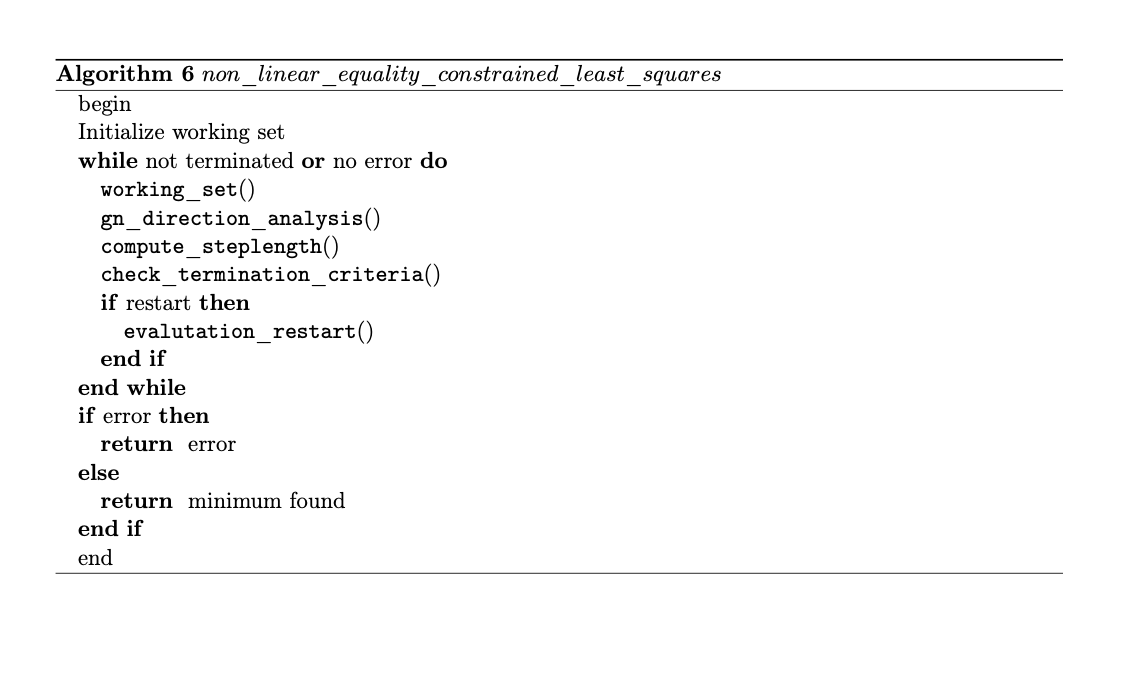

La fonction $\mathtt{working\_set}$ met à jour les nouveaux multiplicateurs de Lagrange et calcule la direction de Gauss-Newton.

In [23]:
function working_set(rx::Vector, cx::Vector, A::Matrix, J::Matrix, ∇fx::Vector,
        qr_AT::QRPivoted{Float64,Array{Float64,2}}, qr_L11::QRPivoted{Float64,Array{Float64,2}}, 
        qr_J2::QRPivoted{Float64,Array{Float64,2}}, rankA::Int64, rankJ2::Int64, previous_step::Iteration)
    
    λ = first_lagrange_mult_estimate(qr_AT, ∇fx)
    previous_step.λ = λ[:]
    p, b_gn, d_gn = gn_search(rx, cx, A, J, qr_AT, qr_L11, qr_J2, rankA, rankJ2)
    return p, b_gn, d_gn, λ
end

working_set (generic function with 1 method)

La fonction $\mathtt{gn\_direction\_analysis}$ analyse la qualité de la direction de descente calculée avec Gauss-Newton. Si elle n'est pas acceptée, une autre analyse détermine quelle méthode est à utiliser pour la recalculer. Les paramètres de l'itération en cours sont modifiés en conséquence.  

In [24]:
function gn_direction_analysis(x::Vector, p_gn::Vector, r::Function, c::Function, A::Matrix, J::Matrix, b_gn::Vector, 
    d_gn::Vector, rankA::Int64, rankJ2::Int64, previous_step::Iteration, λ::Vector,
    qr_AT::QRPivoted{Float64,Array{Float64,2}}, qr_L11::QRPivoted{Float64,Array{Float64,2}},
    qr_J2::QRPivoted{Float64,Array{Float64,2}})
    
    
    method_code = check_gn_direction(x, r, c, J, A, d_gn, b_gn, rankA, rankJ2, previous_step)
    previous_step.code = method_code
    
    # Gauss-Newton direction accepted
    if method_code == 1
        previous_step.b, previous_step.d = d_gn[:], b_gn[:]
        previous_step.t, previous_step.s = rankA, rankJ2
        previous_step.restart = false
        previous_step.p = p_gn[:]
        return p_gn
    
    # Subspace minimization is suggested
    elseif method_code == -1
        t, s, b_sub, d_sub = subspace_dimension(x, r, c, J, A, qr_AT, qr_L11, qr_J2, previous_step)
        JQ1 = J * qr_AT.Q
        p_sub = sub_search_direction(r(x), c(x), J * qr_AT.Q, qr_AT, qr_L11, qr_J2, rankA, s, t)
        previous_step.b, previous_step.d = d_sub[:], b_sub[:]
        previous_step.t, previous_step.s = t, s
        previous_step.restart = false
        previous_step.p = p_sub[:]
        return p_sub
        
    # Newton method is suggested
    else
        p_n = newton_search_direction(x, A, J, r, c, qr_AT, qr_L11, λ, rankA, previous_step)
        n,q = size(A)
        previous_step.t, previous_step.s = -q , q - n
        previous_step.p = p_n[:]
        return p_n
    end
end

gn_direction_analysis (generic function with 1 method)

La fonction $\mathtt{compute\_steplength\_constrained}$ calcule le nouveau vecteur de poids et le pas pour l'itération en cours.

In [25]:
function compute_steplength_constrained(r::Function, J::Function, c::Function, A::Function, x::Vector, 
        p::Vector, ψ::Function, K::Array{Array{Float64,1},1}, previous_step::Iteration, weight_norm::Int64)
    
    
    # Calcul du vecteur de pénalité de l'itération en cours
    w = compute_penalty_weights(r, J, c, A, x, p, ψ, K, weight_norm, previous_step)


    
    # En cas de contraintes d'égalité, la borne supérieure du pas est fixée à 3.
    α_upper = 3.
    α_low = α_upper / 3000
    
    # Première estimation du pas (utilisée comme valeur initiale)
    α0 = min(1, 3 * previous_step.α, α_upper)
    
    # Si la direction est une direction de Newton, le pas vaut nécessairement 1
    if previous_step.code == 2
        α = 1.
    else
        α = linesearch_constrained(r, J, c, A, x, p, w, ψ, α0, α_low, α_upper)
    end
    return α, w
end

compute_steplength_constrained (generic function with 1 method)

In [26]:
# evalutaton restart temporaire

function evaluation_restart!(step::Iteration)
    if previous_step.restart
        println("\n ==== Restart ==== \n")
        previous_step.restart = false
    end
end     

evaluation_restart! (generic function with 1 method)

# Algorithme de résolution d'un problème de moindres carrés non linéaire avec contraintes d'égalité

$\mathtt{nlecls}$ : Non Linear Equality Constrained Least Squares

In [32]:
nlecls = Iteration([0.], [0.], 1., [0.], [0.], 0, 0, [0.], [0.],0., false, true, 1)

function (nlecls::Iteration)(x0::Vector, r::Function, c::Function, jac_r::Function, jac_c::Function)
    
    x = x0[:]
    rx, cx, J, A = r(x), c(x), jac_r(x), jac_c(x)
    q, n = size(A)
    p = zeros(n)
    ε_rank = sqrt(eps(Float64))
    iter = 0
    
    nlecls.x, nlecls.p,  = x[:], p[:]
    nlecls.β = norm(r(x))
    nlecls.t, nlecls.s = q, n-q
    nlecls.λ, nlecls.w, nlecls.b, nlecls.d = zeros(q), zeros(q), zeros(n), zeros(n)

    # Fonction objectif
    f(x::Vector) = 0.5 * dot(r(x),r(x))
    ∇f = x::Vector -> ForwardDiff.gradient(f, x)
    
    # Vecteur de poids et fonction de mérite
    ξ = 4
    K = [zeros(q) for i=1:ξ]
    ψ(x::Vector, w::Vector) = f(x) + 0.5 * dot(w,c(x).^2)
    
    terminated = check_termination_criterias(x, p, rx, cx, A, ∇f(x), nlecls.λ, nlecls)
    println("Point de départ :")
    show(nlecls)
    while !terminated && iter < 100
        
        
        # Factorisations QR et calculs de rang
        qr_AT = qr(transpose(A), Val(true))
        L11 = transpose(qr_AT.R)
        Q1 = qr_AT.Q
        P1 = qr_AT.P

        qr_L11 = qr(transpose(qr_AT.R), Val(true))
        qr_J2 = qr((J * qr_AT.Q)[:, q+1:n], Val(true))
        
        rankA = rank(LowerTriangular(transpose(qr_AT.R)), atol = ε_rank, rtol = ε_rank)
        rankJ2 = rank(UpperTriangular(qr_J2.R), atol = ε_rank, rtol = ε_rank)
        
        p_gn, b_gn, d_gn, λ = working_set(rx , cx, A, J, ∇f(x), qr_AT, qr_L11, qr_J2, rankA, rankJ2, nlecls)
        p = gn_direction_analysis(x, p_gn, r, c, A, J, b_gn, d_gn, rankA, rankJ2, nlecls, λ, qr_AT, qr_L11, qr_J2)
        α, w = compute_steplength_constrained(r, jac_r, c, jac_c, x, p, ψ, K, nlecls, 2)
        
        # Mise à jour du point selon la méthode utilisée
        
        if nlecls.code == 2
            nlecls.α = 1.
            x += p[:]
        else
            nlecls.α = α
            x += α * p[:]
        end
        
        if nlecls.restart evaluation_restart!(nlecls) end
        
        nlecls.p = p[:]
        nlecls.w, nlecls.λ = w[:], λ[:]
        rx, cx, J, A = r(x), c(x), jac_r(x), jac_c(x)
        
        terminated = check_termination_criterias(x, p, rx, cx, A, ∇f(x), λ, nlecls)
        nlecls.x = x[:]
        if iter == 0 nlecls.first = false end
        
        iter += 1
        println("\n Itération n°$iter")
        show(nlecls)
    end
    return x
end

## Tests sur des modèles à ajuster

Vraie fonction: $t\mapsto (t-2)(t-6)(t-10)$

Modèle à ajuster : $f:(t, x_1, x_2, x_3) \mapsto (t-x_1)(t-x_2)(t-x_3) \\ s.c \  \left| \begin{array}{l l}
      x_1+x_2+x_3 = 18 \\
      x_1  x_2  x_3 = 120
   \end{array}\right.$

In [45]:
true_f0(t::Float64) = (t-2)*(t-6)*(t-10)
m = 15
t0 = range(1, 10, length = m)
y0 = true_f0.(t0) + randn(m)

# model, residual function and jacobian
f0(x::Vector, t::Float64) = (t - x[1]) * (t - x[2]) * (t - x[3])
r0(x::Vector) = y0 - (t -> f0(x,t)).(t0)
jac_r0 = x::Vector -> ForwardDiff.jacobian(r0, x)


# constraints function ad jacobian
c0(x::Vector) = [x[1] + x[2] + x[3] - 18, x[1]*x[2]*x[3] - 120]
jac_c0 = x::Vector -> ForwardDiff.jacobian(c0, x)

x0 = nlecls([0., 0., 1.5], r0, c0, jac_r0, jac_c0)

Point de départ :
méthode : Gauss-Newton
x = [0.0, 0.0, 1.5]
p = [0.0, 0.0, 0.0]
α = 0.0009765625000000009

 Itération n°1
méthode : Gauss-Newton
x = [0.09917521428405511, 0.046516058827906034, 1.402648570638039]
p = [33.851806475624116, 15.877481413258579, -33.229287888882695]
α = 0.0029296875000000026

 Itération n°2
méthode : Gauss-Newton
x = [-8.224338126226115, 8.385864810585225, 1.471449721256151]
p = [-1617.9250405054072, 1621.0031287279332, 13.373571933724406]
α = 0.005144560552638503

 Itération n°3
méthode : Gauss-Newton
x = [-7.970356783603967, 8.38919361836379, 1.4667430026987647]
p = [16.45630305533018, 0.2156846209703267, -0.3049640819157666]
α = 0.015433681657915508

 Itération n°4
méthode : Gauss-Newton
x = [-7.219726104419796, 8.399319809442682, 1.4521006251073787]
p = [16.211959786432274, 0.21870329459376725, -0.3162429184846349]
α = 0.04630104497374653

 Itération n°5
méthode : Gauss-Newton
x = [-5.0675300261982645, 8.431009954000539, 1.4029202383007577]
p = [15.4942

3-element Array{Float64,1}:
  5.992020075361304
 10.006646616891404
  2.001333307747292

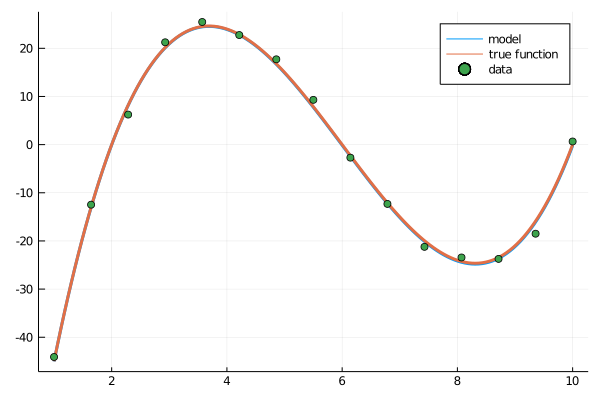

In [46]:
t = range(1, 10, length = 150)
plot(t, (t->f0(x0, t)).(t), lw = 3, label = "model")
plot!(t, true_f0.(t), lw = 3, label = "true function")
scatter!(t0, y0, label = "data")

Vraie fonction : $t \mapsto 0.1t + \dfrac{0.17}{t}$

Modèle à ajuster : $f:(t,x_1, x_2) \mapsto x_1t + \dfrac{x_2}{t} \\ s.c\  2x_1 + x_2 = 0.37$



In [50]:
true_f1(t::Float64) = 0.1*t^2 + 0.17/t
m = 20
t1 = range(0.1, 10, length = m)
y1 = true_f1.(t1) + randn(m)

# model, residual function and jacobian
f1(x::Vector, t::Float64) = x[1]*t^2 + x[2]/t
r1(x::Vector) = y1 - (t -> f1(x,t)).(t1)
jac_r1 = x::Vector -> ForwardDiff.jacobian(r1, x)


# constraints function ad jacobian
c1(x::Vector) = [2*x[1] + x[2] - 0.37]#, 3*x[1] - 5*x[2] + 0.1]
jac_c1 = x::Vector -> ForwardDiff.jacobian(c1, x)

x1 = nlecls([0., 0.], r1, c1, jac_r1, jac_c1)




Point de départ :
méthode : Gauss-Newton
x = [0.0, 0.0]
p = [0.0, 0.0]
α = 1.0

 Itération n°1
méthode : Gauss-Newton
x = [0.0962599559792435, 0.17748008804151288]
p = [0.0962599559792435, 0.17748008804151288]
α = 1.0

 Itération n°2
méthode : Gauss-Newton
x = [0.0962599559792435, 0.177480088041513]
p = [5.8480714811278585e-18, 9.932615950025995e-17]
α = 1.0


2-element Array{Float64,1}:
 0.0962599559792435
 0.177480088041513

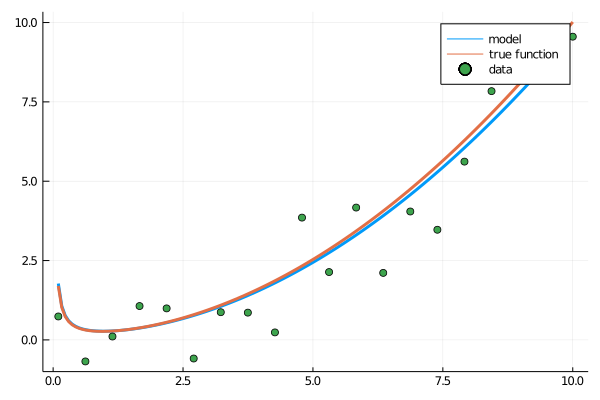

In [51]:
t = range(0.1, 10, length = 150)
plot(t, (t->f1(x1, t)).(t), lw = 3, label = "model")
plot!(t, true_f1.(t), lw=3,label = "true function")
scatter!(t1, y1, label = "data")

Vraie fonction : $t \mapsto 1 - \dfrac{t^2}{2} + \dfrac{t^4}{24}$

Modèle à ajuster : $f:(t, x_1, x_2) \mapsto 1 + x_1t^2 + {x_2}^3\dfrac{t^4}{3} \\
s.c\ x_1 + 2x_2 = \dfrac{1}{2}$

In [52]:
true_f2(t::Float64) = 1 - t^2/2 + t^4/24
m = 8
t2 = range(0, 6, length = m)
y2 = true_f2.(t2) + randn(m)

# model, residual function and jacobian
f2(x::Vector, t::Float64) = 1 + x[1]*t^2 + x[2]^3 * t^4 /3
r2(x::Vector) = y2 - (t -> f2(x,t)).(t2)
jac_r2 = x::Vector -> ForwardDiff.jacobian(r2, x)


# constraints function ad jacobian
c2(x::Vector) = [x[1] + 2 * x[2] - 0.5]
jac_c2 = x::Vector -> ForwardDiff.jacobian(c2, x)

x2 = nlecls([0.5, 0.1], r2, c2, jac_r2, jac_c2)

Point de départ :
méthode : Gauss-Newton
x = [0.5, 0.1]
p = [0.0, 0.0]
α = 1.0

 Itération n°1
méthode : Gauss-Newton
x = [0.7675083746869112, -0.13375418734345562]
p = [0.26750837468691124, -0.23375418734345563]
α = 1.0

 Itération n°2
méthode : Gauss-Newton
x = [0.6958758786182013, -0.09793793930910066]
p = [-0.07163249606870986, 0.03581624803435495]
α = 1.0

 Itération n°3
méthode : Gauss-Newton
x = [0.7237570018886098, -0.1118785009443049]
p = [0.02788112327040847, -0.013940561635204244]
α = 1.0

 Itération n°4
méthode : Gauss-Newton
x = [0.7168014073357122, -0.10840070366785609]
p = [-0.006955594552897623, 0.003477797276448813]
α = 1.0

 Itération n°5
méthode : Gauss-Newton
x = [0.7188981697023067, -0.10944908485115334]
p = [0.002096762366594495, -0.0010483811832972477]
α = 1.0

 Itération n°6
méthode : Gauss-Newton
x = [0.7182941362001973, -0.10914706810009867]
p = [-0.0006040335021093522, 0.0003020167510546763]
α = 1.0

 Itération n°7
méthode : Gauss-Newton
x = [0.71847056505641

2-element Array{Float64,1}:
  0.7184341870376356
 -0.10921709351881781

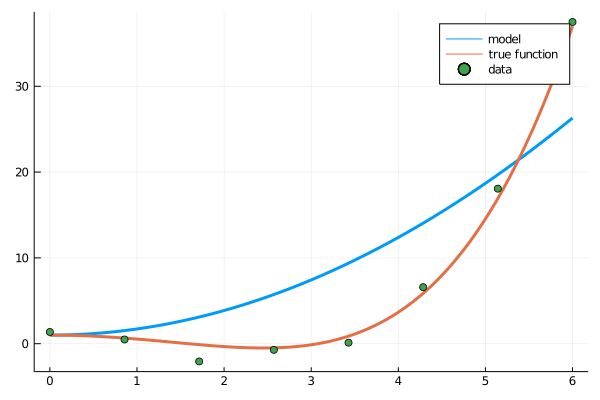

In [53]:
t = range(0, 6, length = 150)
plot(t, (t->f2(x2, t)).(t), lw = 3, label = "model")
plot!(t, true_f2.(t), lw=3,label = "true function")
scatter!(t2, y2, label = "data")